# Detecting Drift on Weather Dataset Partitions

In this tutorial, we'll use a weather dataset to demonstrate how to detect drift on partitions of a dataset. The weather dataset contains hourly weather observations from 36 weather stations in Moscow, Russia. The dataset is available on [Kaggle](https://www.kaggle.com/muthuj7/weather-dataset).

First, we'll import the necessary libraries and load the dataset. Download the dataset and place it in the `data` directory, within this `examples` directory.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from gate import summarize, detect_drift

import matplotlib.pyplot as plt
import seaborn as sns

/Users/shreyashankar/miniforge3/envs/dataval/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load and process data types

all_data = pd.read_csv('data/weatherHistory.csv')
all_data["Formatted Date"] = pd.to_datetime(all_data["Formatted Date"], utc=True)
all_data = all_data.sort_values("Formatted Date")

In [4]:
# Partition data by date and print some values

all_data["year_quarter"] = all_data["Formatted Date"].dt.year.astype(str) + "_" + all_data["Formatted Date"].dt.quarter.astype(str)


# Drop partitions that have less than 100 rows
all_data = all_data.groupby("year_quarter").filter(lambda x: len(x) > 100).reset_index(drop=True)

print("Num partitions: ", len(all_data["year_quarter"].unique()))
print("Num rows: ", len(all_data))

all_data.head()

Num partitions:  44
Num rows:  96452


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,year_quarter
0,2006-01-01 00:00:00+00:00,Mostly Cloudy,rain,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,0.0,1016.15,Mostly cloudy throughout the day.,2006_1
1,2006-01-01 01:00:00+00:00,Mostly Cloudy,rain,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,0.0,1015.87,Mostly cloudy throughout the day.,2006_1
2,2006-01-01 02:00:00+00:00,Overcast,rain,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,0.0,1015.56,Mostly cloudy throughout the day.,2006_1
3,2006-01-01 03:00:00+00:00,Mostly Cloudy,rain,1.183333,-2.744444,0.86,13.9426,134.0,9.9015,0.0,1014.98,Mostly cloudy throughout the day.,2006_1
4,2006-01-01 04:00:00+00:00,Mostly Cloudy,rain,1.205556,-3.072222,0.85,15.9068,149.0,9.9820,0.0,1014.08,Mostly cloudy throughout the day.,2006_1


Note that our partition key is the quarter and year of the observation. We'll use this partition key to detect drift on each partition. We expect that the weather in each quarter of the year will be similar, but maybe some of the data is missing or the weather is different.

## Compute Partition Summaries

We'll now use GATE to compute partition summaries.

In [5]:
# Specify columns to compute summary statistics for

columns = all_data.columns.to_list()
columns.remove("Formatted Date")
columns.remove("year_quarter")

In [6]:
columns

['Summary',
 'Precip Type',
 'Temperature (C)',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Loud Cover',
 'Pressure (millibars)',
 'Daily Summary']

In [7]:
all_data

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,year_quarter
0,2006-01-01 00:00:00+00:00,Mostly Cloudy,rain,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,0.0,1016.15,Mostly cloudy throughout the day.,2006_1
1,2006-01-01 01:00:00+00:00,Mostly Cloudy,rain,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,0.0,1015.87,Mostly cloudy throughout the day.,2006_1
2,2006-01-01 02:00:00+00:00,Overcast,rain,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,0.0,1015.56,Mostly cloudy throughout the day.,2006_1
3,2006-01-01 03:00:00+00:00,Mostly Cloudy,rain,1.183333,-2.744444,0.86,13.9426,134.0,9.9015,0.0,1014.98,Mostly cloudy throughout the day.,2006_1
4,2006-01-01 04:00:00+00:00,Mostly Cloudy,rain,1.205556,-3.072222,0.85,15.9068,149.0,9.9820,0.0,1014.08,Mostly cloudy throughout the day.,2006_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96447,2016-12-31 18:00:00+00:00,Mostly Cloudy,rain,0.488889,-2.644444,0.86,9.7566,167.0,8.0178,0.0,1020.03,Mostly cloudy throughout the day.,2016_4
96448,2016-12-31 19:00:00+00:00,Mostly Cloudy,rain,0.072222,-3.050000,0.88,9.4185,169.0,7.2450,0.0,1020.27,Mostly cloudy throughout the day.,2016_4
96449,2016-12-31 20:00:00+00:00,Mostly Cloudy,snow,-0.233333,-3.377778,0.89,9.2736,175.0,9.5795,0.0,1020.50,Mostly cloudy throughout the day.,2016_4
96450,2016-12-31 21:00:00+00:00,Mostly Cloudy,snow,-0.472222,-3.644444,0.91,9.2414,182.0,8.4042,0.0,1020.65,Mostly cloudy throughout the day.,2016_4


In [8]:
summaries = summarize(all_data, columns=columns, partition_key="year_quarter")

print("Num summaries: ", len(summaries)) # Should be one per partition

Num summaries:  44


We can print out a summary of the dataset to see what the data looks like.

In [9]:
summaries[0].summary

,year_quarter,column,coverage,mean,num_unique_values,occurrence_ratio,p50,p95
0,2006_1,Apparent Temperature (C),1.0,-1.689575,NaN,NaN,-2.238889,11.927778
1,2006_1,Daily Summary,1.0,NaN,40.0,0.100000,NaN,NaN
2,2006_1,Humidity,1.0,0.818122,NaN,NaN,0.850000,0.960000
3,2006_1,Loud Cover,1.0,0.000000,NaN,NaN,0.000000,0.000000
4,2006_1,Precip Type,1.0,NaN,2.0,0.539815,NaN,NaN
5,2006_1,Pressure (millibars),1.0,997.688660,NaN,NaN,1018.039978,1036.520020
6,2006_1,Summary,1.0,NaN,12.0,0.328704,NaN,NaN
7,2006_1,Temperature (C),1.0,0.972114,NaN,NaN,0.216667,11.927778
8,2006_1,Visibility (km),1.0,8.334718,NaN,NaN,9.708300,15.375500
9,2006_1,Wind Bearing (degrees),1.0,184.213882,NaN,NaN,189.000000,344.000000


## Detect Drift

With the partition summaries, we can now detect drift on each partition. We'll use the `detect_drift` function to detect drift on each partition. 

For each partition, we detect drift with respect to its earlier partition summaries. We skip the first few partitions, since there aren't many partitions to compare them to.

We pass in `clustering=False` to disable clustering on columns.

In [10]:
partition_names = [s.partition for s in summaries]

In [11]:
drifted_partitions = {}

for i in range(6, len(summaries)):
    drift_results = detect_drift(summaries[i], summaries[:i], cluster=False)
    if drift_results.is_drifted:
        print(f"Drift detected in partition {partition_names[i]}!")
        drifted_partitions[partition_names[i]] = drift_results
        # print(drift_results.drill_down())

Drift detected in partition 2012_2!
Drift detected in partition 2013_3!
Drift detected in partition 2014_2!
Drift detected in partition 2014_4!
Drift detected in partition 2016_4!


### Inspect Drift Summary for First Drifted Partition

Looks like there's some drift in a few of the partitions! We can print out the drift summary to see which columns have drifted. We'll start with the first drifted partition.

In [12]:
def get_summary(partition_name):
    for summary in summaries:
        if summary.partition == partition_name:
            return summary
    return None


partition_name = list(drifted_partitions.keys())[0]
drift_results = drifted_partitions[partition_name]
print(drift_results)

Drift score: 7.3200 (100.00% percentile)
Top drifted columns:
                                 statistic   z-score
column                                              
Precip Type                       coverage -4.902905
Pressure (millibars)                  mean -2.286129
Visibility (km)                        p50  1.363489
Humidity                               p50 -1.105691
Temperature (C)                        p95  0.833868
Apparent Temperature (C)               p95  0.822340
Summary                   occurrence_ratio  0.806668
Wind Speed (km/h)                      p50  0.650368
Daily Summary             occurrence_ratio  0.580174
Wind Bearing (degrees)                mean -0.464176


Wow, it looks like the coverage of the Precipitation Type column is lower in the drifted partition. The magnitude of the z-score for the coverage is high. Let's look at the partition summary for the drifted partition.

In [13]:
drifted_ps = get_summary(partition_name)
drifted_ps.summary

,year_quarter,column,coverage,mean,num_unique_values,occurrence_ratio,p50,p95
0,2012_2,Apparent Temperature (C),1.000000,16.975292,NaN,NaN,17.222221,28.777779
1,2012_2,Daily Summary,1.000000,NaN,31.0,0.208791,NaN,NaN
2,2012_2,Humidity,1.000000,0.648732,NaN,NaN,0.650000,0.930000
3,2012_2,Loud Cover,1.000000,0.000000,NaN,NaN,0.000000,0.000000
4,2012_2,Precip Type,0.934524,NaN,3.0,0.926740,NaN,NaN
5,2012_2,Pressure (millibars),1.000000,963.404053,NaN,NaN,1012.000000,1021.400024
6,2012_2,Summary,1.000000,NaN,12.0,0.443223,NaN,NaN
7,2012_2,Temperature (C),1.000000,17.318073,NaN,NaN,17.222221,28.977777
8,2012_2,Visibility (km),1.000000,11.651963,NaN,NaN,11.157300,16.100000
9,2012_2,Wind Bearing (degrees),1.000000,184.668045,NaN,NaN,180.000000,340.000000


The lower coverage indicates missing data for precipitation type.

### Inspect Drift Summary for Second Drifted Partition

Let's look at the second drifted partition, Q2 2014.

In [14]:
partition_name = list(drifted_partitions.keys())[1]
drift_results = drifted_partitions[partition_name]
print(drift_results)

Drift score: 4.9625 (96.67% percentile)
Top drifted columns:
                                  statistic   z-score
column                                               
Visibility (km)                         p50  3.937467
Wind Bearing (degrees)                  p50  2.083488
Wind Speed (km/h)                       p50 -1.304203
Daily Summary             num_unique_values -1.288411
Temperature (C)                         p95  1.172718
Summary                    occurrence_ratio  1.152071
Apparent Temperature (C)                p95  1.115970
Humidity                                p50 -1.019217
Precip Type               num_unique_values -0.965535
Pressure (millibars)                    p95 -0.951415


Looks like the visibility p50 and the summary occurrence_ratio have drifted. Let's visualize both of these.

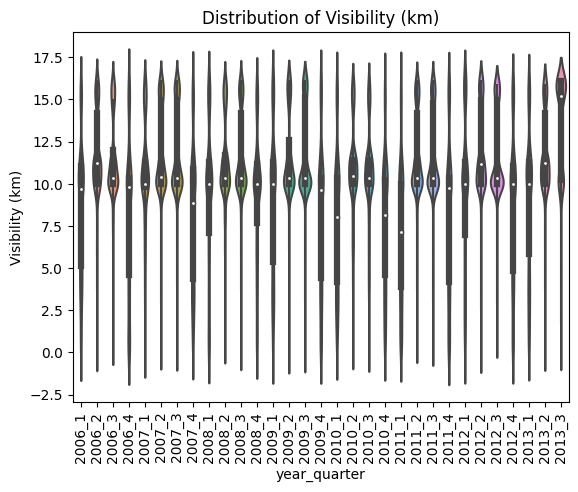

In [15]:
sns.violinplot(x="year_quarter", y="Visibility (km)", data= all_data[all_data["year_quarter"] <= partition_name])
plt.xticks(rotation=90)
plt.title("Distribution of Visibility (km)")
plt.show()

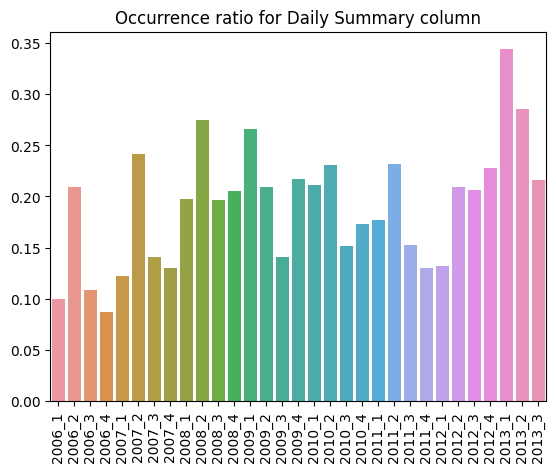

In [16]:
or_for_earlier_partitions = {
    pname: get_summary(pname).summary.set_index("column").loc["Daily Summary"]["occurrence_ratio"] for pname in partition_names if pname <= partition_name
}

sns.barplot(x=list(or_for_earlier_partitions.keys()), y=list(or_for_earlier_partitions.values()))
plt.xticks(rotation=90)
plt.title("Occurrence ratio for Daily Summary column")
plt.show()

Looks like the visibility was higher, and there were many different summaries of weather in Q2 2014. We can print out the distinct weather summary types:

In [18]:
all_data[all_data["year_quarter"] == partition_name]["Daily Summary"].value_counts()

Daily Summary
Partly cloudy throughout the day.                                                                       478
Mostly cloudy throughout the day.                                                                       336
Partly cloudy starting in the morning.                                                                  240
Partly cloudy starting in the afternoon continuing until evening.                                       168
Partly cloudy starting in the morning continuing until evening.                                         168
Partly cloudy until evening.                                                                            144
Partly cloudy starting in the morning continuing until night.                                           144
Partly cloudy starting overnight continuing until evening.                                               72
Partly cloudy until night.                                                                               72
Overcast throu

### Inspect Drift Summary for Third Drifted Partition

In [19]:
partition_name = list(drifted_partitions.keys())[2]
drift_results = drifted_partitions[partition_name]
print(f"Looking at partition {partition_name}:")
print(drift_results)

Looking at partition 2014_2:
Drift score: 5.1100 (96.97% percentile)
Top drifted columns:
                                  statistic   z-score
column                                               
Visibility (km)                         p50  3.268521
Daily Summary              occurrence_ratio  3.195367
Wind Bearing (degrees)                  p95  1.911883
Pressure (millibars)                    p95 -1.456871
Summary                   num_unique_values -1.249163
Precip Type               num_unique_values -0.996285
Humidity                               mean -0.725901
Apparent Temperature (C)               mean  0.637927
Temperature (C)                        mean  0.609680
Wind Speed (km/h)                       p95  0.356977


Wow, looks like the Pressure column mean is lower in the drifted partition. We can plot the means for this column over time to visualize the distribution shift.

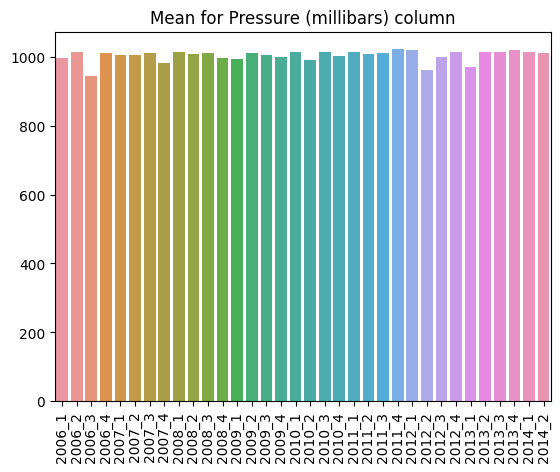

In [20]:
mean_for_earlier_partitions = {
    pname: get_summary(pname).summary.set_index("column").loc["Pressure (millibars)"]["mean"] for pname in partition_names if pname <= partition_name
}

sns.barplot(x=list(mean_for_earlier_partitions.keys()), y=list(mean_for_earlier_partitions.values()))
plt.xticks(rotation=90)
plt.title("Mean for Pressure (millibars) column")
plt.show()

And if we visualize the entire distribution of the pressure column, we'll see that there were several low-pressure observations.

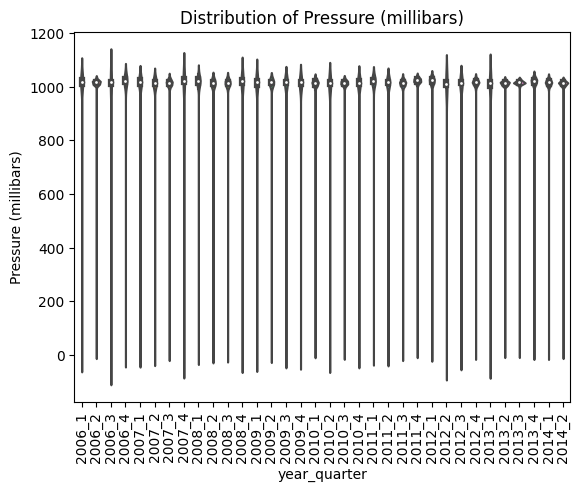

In [21]:
sns.violinplot(x="year_quarter", y="Pressure (millibars)", data= all_data[all_data["year_quarter"] <= partition_name])
plt.xticks(rotation=90)
plt.title("Distribution of Pressure (millibars)")
plt.show()

Additionally, the Wind Bearing (degrees) column has a lower p95, indicating that there were fewer high wind bearing observations in the drifted partition. We can visualize these distributions too.

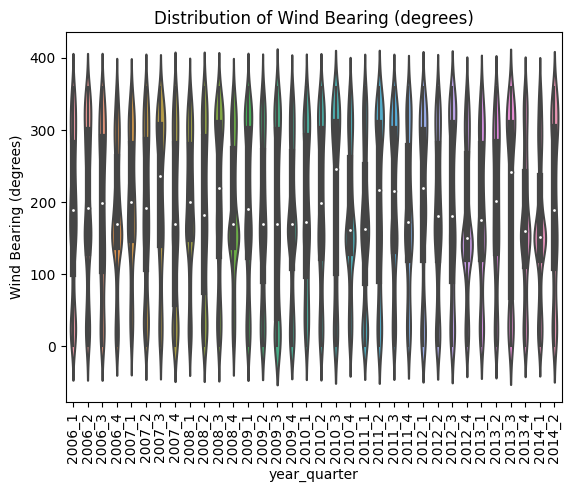

In [22]:
sns.violinplot(x="year_quarter", y="Wind Bearing (degrees)", data= all_data[all_data["year_quarter"] <= partition_name])
plt.xticks(rotation=90)
plt.title("Distribution of Wind Bearing (degrees)")
plt.show()

## Conclusion

We've only inspected a few partitions, but we can see that GATE can detect drift on partitions of a dataset. We can also see that the drift summary can help us understand the drift in each partition.